In [1]:
import os
import gym
from gym import wrappers
import numpy as np

In [2]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class DDQNAgent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='ddqn_model.h5', replace_target=100):
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.replace_target = replace_target
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_target = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :] #so that we can deef it to the nn
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_next = self.q_target.predict(new_state)
            q_eval = self.q_eval.predict(new_state)
            q_pred = self.q_eval.predict(state)

            max_actions = np.argmax(q_eval, axis=1)

            q_target = q_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                    self.gamma*q_next[batch_index, max_actions.astype(int)]*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min
            if self.memory.mem_cntr % self.replace_target == 0:
                self.update_network_parameters()

    def update_network_parameters(self):
        self.q_target.model.set_weights(self.q_eval.model.get_weights())

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model('ddqn_model.h5')
        # if we are in evaluation mode we want to use the best weights for
        # q_target
        if self.epsilon == 0.0:
            self.update_network_parameters()

Using TensorFlow backend.


In [4]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    ddqn_agent = DDQNAgent(alpha=0.0005, gamma=0.99, n_actions=2, epsilon=1.0,
                  batch_size=64, input_dims=4)
    n_games = 300
    ddqn_scores = []
    eps_history = []
    #ddqn_agent.load_model()
    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = ddqn_agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            ddqn_agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            ddqn_agent.learn()
        eps_history.append(ddqn_agent.epsilon)

        ddqn_scores.append(score)

        avg_score = np.mean(ddqn_scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            ddqn_agent.save_model()

c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode:  0 score: 20.00  average score 20.00
episode:  1 score: 10.00  average score 15.00
episode:  2 score: 11.00  average score 13.67
episode:  3 score: 16.00  average score 14.25
episode:  4 score: 11.00  average score 13.60
episode:  5 score: 11.00  average score 13.17
episode:  6 score: 13.00  average score 13.14


c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


episode:  7 score: 40.00  average score 16.50
episode:  8 score: 21.00  average score 17.00
episode:  9 score: 13.00  average score 16.60
episode:  10 score: 9.00  average score 15.91
episode:  11 score: 12.00  average score 15.58
episode:  12 score: 16.00  average score 15.62
episode:  13 score: 19.00  average score 15.86
episode:  14 score: 20.00  average score 16.13
episode:  15 score: 10.00  average score 15.75
episode:  16 score: 20.00  average score 16.00
episode:  17 score: 12.00  average score 15.78
episode:  18 score: 11.00  average score 15.53
episode:  19 score: 10.00  average score 15.25
episode:  20 score: 20.00  average score 15.48
episode:  21 score: 18.00  average score 15.59
episode:  22 score: 17.00  average score 15.65
episode:  23 score: 15.00  average score 15.62
episode:  24 score: 29.00  average score 16.16
episode:  25 score: 29.00  average score 16.65
episode:  26 score: 200.00  average score 23.44
episode:  27 score: 200.00  average score 29.75
episode:  28 sc

episode:  175 score: 200.00  average score 188.22
episode:  176 score: 200.00  average score 188.22
episode:  177 score: 200.00  average score 188.22
episode:  178 score: 200.00  average score 188.22
episode:  179 score: 200.00  average score 188.22
episode:  180 score: 200.00  average score 188.22
episode:  181 score: 200.00  average score 188.22
episode:  182 score: 200.00  average score 188.22
episode:  183 score: 200.00  average score 188.22
episode:  184 score: 200.00  average score 188.22
episode:  185 score: 200.00  average score 188.22
episode:  186 score: 200.00  average score 188.22
episode:  187 score: 200.00  average score 188.22
episode:  188 score: 200.00  average score 188.22
episode:  189 score: 200.00  average score 188.22
episode:  190 score: 200.00  average score 188.22
episode:  191 score: 200.00  average score 188.22
episode:  192 score: 200.00  average score 188.22
episode:  193 score: 200.00  average score 188.22
episode:  194 score: 200.00  average score 188.22


Text(0.5,1,'DDQN for CartPole-v0')

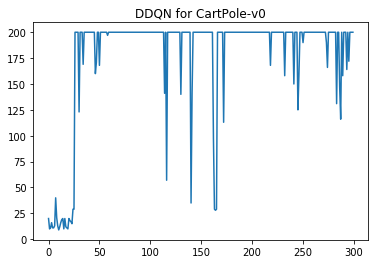

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(n_games),ddqn_scores)
plt.title('DDQN for CartPole-v0')